In [1]:

library("readr") # For reading data files
library("dplyr") # de-facto library for data preprosessing
library("ggplot2") # de-facto library for visualization



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


In [2]:
library("rstan") 
library("bayesplot")

Loading required package: StanHeaders
rstan (Version 2.18.2, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
This is bayesplot version 1.7.1
- Online documentation and vignettes at mc-stan.org/bayesplot
- bayesplot theme set to bayesplot::theme_default()
   * Does _not_ affect other ggplot2 plots
   * See ?bayesplot_theme_set for details on theme setting


In [3]:
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

In [4]:
d <-  read_csv("https://raw.githubusercontent.com/dins/snow-depth/master/kaisaniemi.csv", 
               col_types = cols(`Lumensyvyys (cm)` = col_character())) %>%
      setNames(c("year", "month", "day", "clock", "tzone", "snow", "temp")) %>%
      mutate(date = ISOdate(year, month, day), 
             snow = ifelse(snow==FALSE, 0, as.numeric(snow)), 
             snow = ifelse(snow < 0, 0, snow), 
             is_snow = snow > 0) %>%
      select(date, year, month, day, snow, is_snow, temp)
saveRDS(d, file="kaisaniemi_daily.rds")

In [5]:
tail(d)

date,year,month,day,snow,is_snow,temp
2019-11-28 12:00:00,2019,11,28,0,FALSE,3.7
2019-11-29 12:00:00,2019,11,29,0,FALSE,3.6
2019-11-30 12:00:00,2019,11,30,2,TRUE,-3.0
2019-12-01 12:00:00,2019,12,1,2,TRUE,-0.5
2019-12-02 12:00:00,2019,12,2,2,TRUE,-0.9
2019-12-03 12:00:00,2019,12,3,2,TRUE,-0.4


In [6]:
christmas <- d %>% filter(!is.na(snow))%>% filter(day==24 & month==12)
readr::write_csv(christmas, "kaisaniemi_christmas.csv")



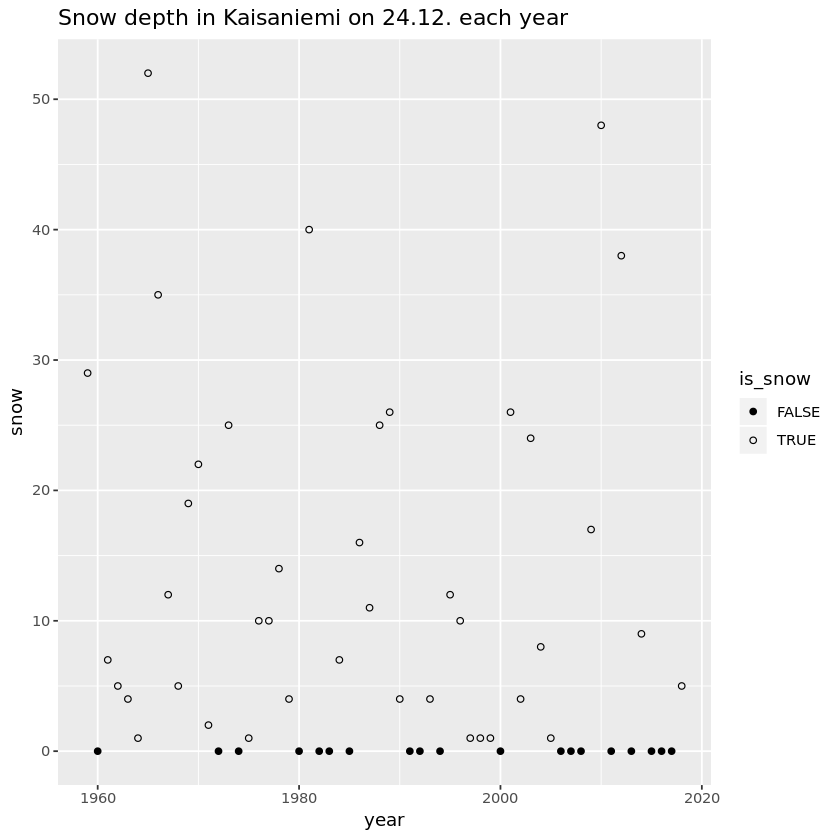

In [7]:
ggplot(christmas, aes(x=year, y=snow)) + 
  geom_point(aes(shape=is_snow)) + 
  scale_shape_manual(values=c(19, 1)) + 
  #geom_smooth(method="lm") + 
  labs(title = "Snow depth in Kaisaniemi on 24.12. each year")

In [17]:
stan_data <- with(christmas, list(decade=(year-2000)/10, is_snow=is_snow, N=length(is_snow)))


In [9]:
logistic_reggr_code <- "
data {
   int N;
      int<lower=0, upper=1> is_snow[N];
   real decade[N]; 
}
parameters {
   real b;
   real k; 
}
model {
   for (i in 1:N) is_snow[i] ~ bernoulli_logit(k * decade[i] + b); 
}
generated quantities {
   real prob[N];
   for (i in 1:N) prob[i] = inv_logit(k* decade[i] + b);
}
"

In [10]:
m <- stan_model(model_code = logistic_reggr_code)
fit <- sampling(m, data=stan_data)
fit


Inference for Stan model: 34953b98adb6671f2cdcb0ae4c96ad4f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean   sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
b          0.45    0.01 0.33  -0.18   0.23   0.44   0.67   1.07  2156    1
k         -0.36    0.00 0.18  -0.74  -0.48  -0.36  -0.24  -0.03  2049    1
prob[1]    0.86    0.00 0.08   0.67   0.81   0.87   0.91   0.97  3140    1
prob[2]    0.85    0.00 0.08   0.67   0.81   0.86   0.91   0.96  3171    1
prob[3]    0.85    0.00 0.08   0.66   0.81   0.86   0.91   0.96  3205    1
prob[4]    0.84    0.00 0.08   0.66   0.80   0.86   0.90   0.96  3239    1
prob[5]    0.84    0.00 0.08   0.66   0.80   0.85   0.90   0.95  3276    1
prob[6]    0.84    0.00 0.08   0.66   0.79   0.85   0.89   0.95  3315    1
prob[7]    0.83    0.00 0.08   0.66   0.79   0.84   0.89   0.95  3355    1
prob[8]    0.83    0.00 0.08   0.66   0.78   0.84   0.89   0.94  3398   

'pars' not specified. Showing first 10 parameters by default.


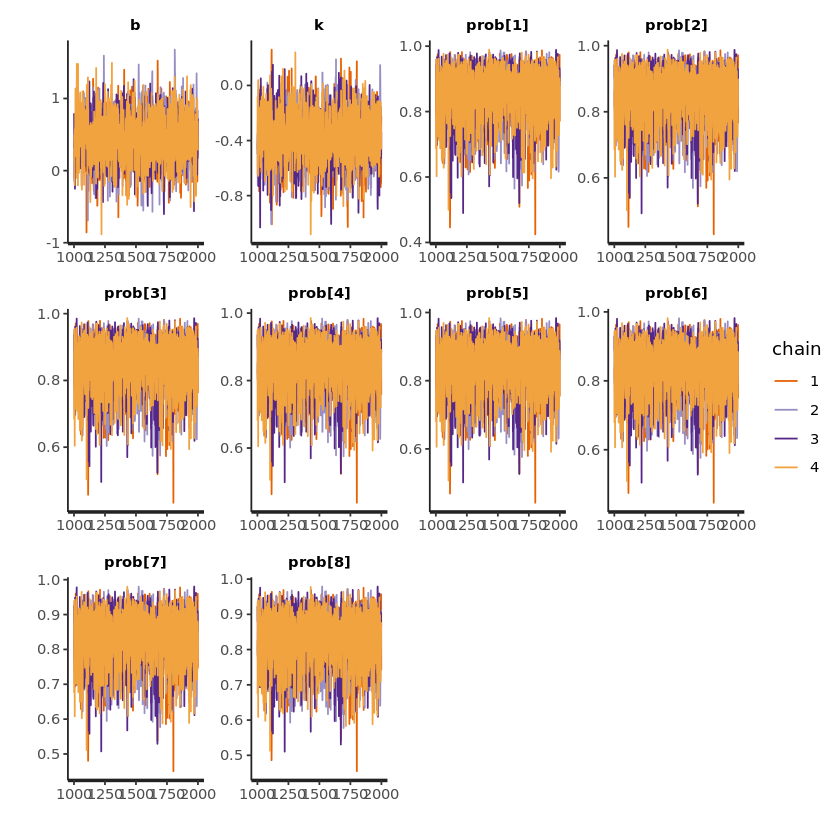

In [11]:
traceplot(fit)

ci_level: 0.8 (80% intervals)
outer_level: 0.95 (95% intervals)


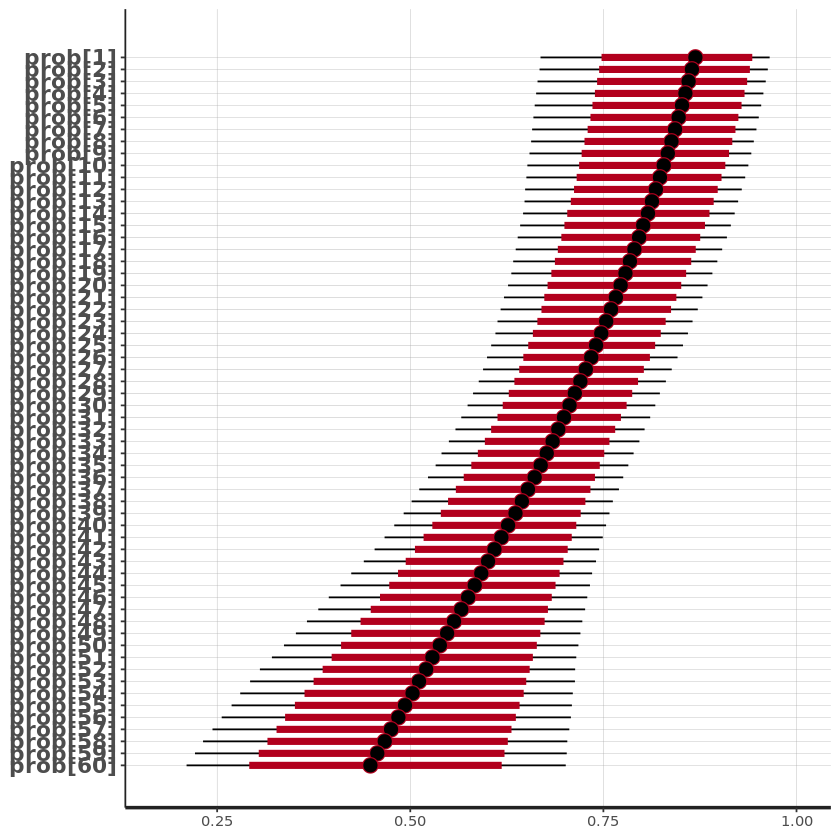

In [12]:
#hist(posterior_samples(fit, "k")$k, n=100)
#plot(fit, pars=c("k", "b"))
plot(fit, pars="prob")

In [13]:
# Has snow cover decreased significantly?
diff_samples <- extract(fit, "prob[1]")[[1]] - extract(fit, "prob[60]")[[1]]
# probability of decrease
mean(diff_samples > 0)

[1] 0.98375

In [14]:
# Now estimate snow propability for 2019
decade_2019 <- (2019 - 2000) / 10
post_draws <- extract(fit)
library(boot)
predictions <- inv.logit(post_draws$b + post_draws$k * decade_2019)

In [18]:
mean(predictions)

[1] 0.4443933

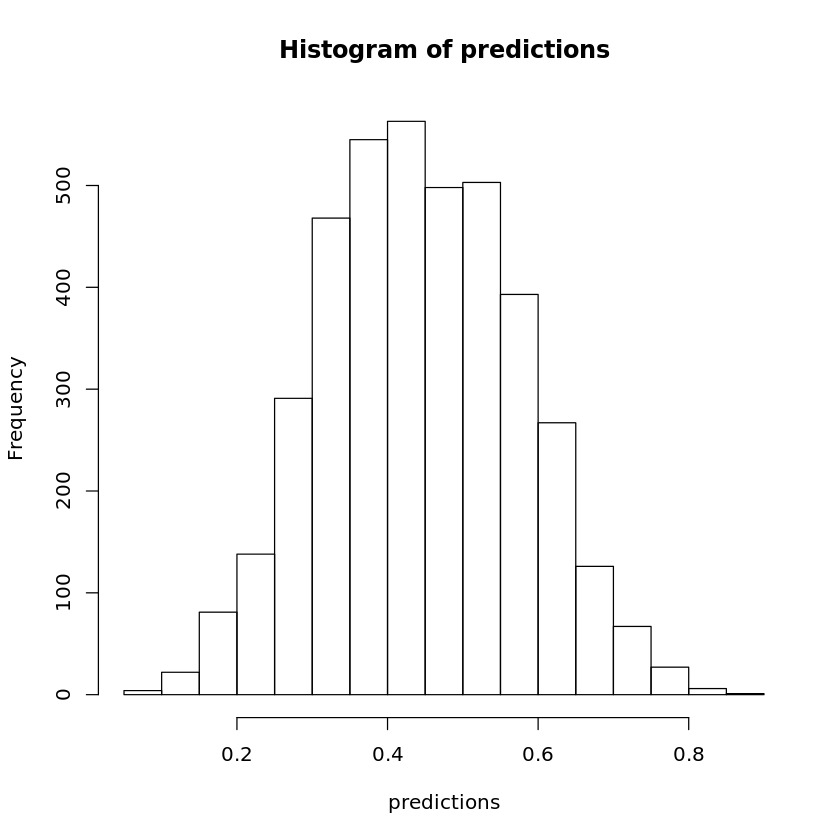

In [16]:
hist(predictions)